In [29]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from IPython.display import display , display_markdown , display_pretty , display_html
import seaborn as sns

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
np.random.seed(91828)


In [3]:
def class_to_int(label , cl):
    temp = []
    for i in range(len(label)):
        #print(label[i])
        for j in range(len(cl)):
            if(label[i]==cl[j]):
                temp.append(j) 
    return temp
classes = ['BH' ,'NS' ]
ns_n = 0 
bh_n = 0


In [4]:

def get_xy(data):
    y = data['class']
    s = data['significance']
    info = data[['src_n' , 'src_id']]
    x = data.drop(columns=[ 'class' ,'src_n' ,'src_id' , 'significance'])
    #display(x)
    y_train_int = class_to_int(y, classes)
    one_hot_y_train =  to_categorical(y_train_int)
    global ns_n 
    global bh_n
    ns_n = float(y.value_counts()['NS']) 
    bh_n =  float(y.value_counts()['BH'])    
    print(ns_n , bh_n)
    return x , one_hot_y_train

In [5]:
def fit_model(model , x_train , one_hot_y_train , verbose=0 , validation=0.2):
    global ns_n 
    global bh_n 
    class_weight = {0: (ns_n/bh_n),
                    1: 1}
    history = model.fit(x_train, one_hot_y_train, batch_size=64, epochs=120, validation_split=validation, class_weight=class_weight, verbose=verbose )
    return history

In [6]:
def res_score(model , x , y ):
    y_prob = model.predict(x)
    y_pred = np.zeros_like(y_prob)
    y_pred[np.arange(len(y_prob)), y_prob.argmax(1)] = 1
    cf = np.matrix(np.matmul(y.T , y_pred))
    total = cf.sum()
    row_sum = cf.sum(axis=0)
    acc = np.trace(cf) / total 
    col_sum = cf.sum(axis=1) 
    #print(cf)
    return cf , acc


#_ , score = res_score(model , x , one_hot_y_train)
#print(score)

In [8]:
def src_split(data_sent , s = (5 , 8) ):
    data = data_sent.copy().reset_index(drop=True)
    data_bh =  data[data['class']=='BH'].sample(frac=1)
    data_ns =  data[data['class']=='NS'].sample(frac=1)
    n_bh  , n_ns = s 
    
    src_bh =  np.unique(data_bh['src_id'])
    np.random.shuffle(src_bh)
    src_ns = np.unique(data_ns['src_id'])
    np.random.shuffle(src_ns)
    s_bh = len(src_bh) - n_bh 
    s_ns = len(src_ns) - n_ns 
    print(s_bh , s_ns)
    src_bh_train = src_bh[:s_bh]
    src_bh_test = src_bh[s_bh:]
    src_ns_train = src_ns[:s_ns]
    src_ns_test = src_ns[s_ns:]
    print(src_bh_test)
    train_bh = data_bh[data_bh['src_id'].isin(src_bh_train)].reset_index(drop=True)
    test_bh = data_bh[data_bh['src_id'].isin(src_bh_test)].reset_index(drop=True)

    train_ns = data_ns[data_ns['src_id'].isin(src_ns_train)].reset_index(drop=True)
    test_ns = data_ns[data_ns['src_id'].isin(src_ns_test)].reset_index(drop=True)

    train = pd.concat([train_bh , train_ns]).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)

    test = pd.concat([test_bh , test_ns]).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)
    return train , test 

def obs_split(data_sent , s = 0.8):
    data = data_sent.copy()
    data = data.sample(frac=1)
    split_no = int(len(data)*s)
    train = data[:split_no]
    test = data[split_no:]
    return train, test

In [7]:
# MC Validation Code
from tqdm import tqdm
from sklearn.model_selection import train_test_split
def mc_validation(model_func = '' , x = '' , split_data = '' , s=0.8 , model_name = '' , d_type = '' , impute_method = ''):
    from sklearn.model_selection import KFold
    kfold = KFold(8, True, 1)
    #k-fold cross-validation
    train_acc = []
    test_acc = []
    index = np.arange(0,len(x))
    split_no = int(len(x)*s)
    print('split_no' , split_no)
    np.random.shuffle(index)
    data = x.copy()
    data = data.sample(frac=1)
    for i in tqdm(range(32)):
        data = data.sample(frac=1)
        x =  data.drop(columns=['class' , 'src_n' ,'src_id' ,'significance'])
        y = data['class']
        x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , stratify=y)
        x_train.insert(0 , 'class' , y_train)
        x_test.insert(0 , 'class' , y_test)
        #x_train , x_test = split_data(data)
        tf_data_train = tfdf.keras.pd_dataframe_to_tf_dataset(x_train,label="class")
        tf_data_test = tfdf.keras.pd_dataframe_to_tf_dataset(x_test,label="class")
        model = model_func()
        #with sys_pipes():
        model.fit(tf_data_train , verbose=0)
        model.compile(metrics=['accuracy'])

        evaluation = model.evaluate(tf_data_train, return_dict=True)
        _ ,  train_acc_temp = evaluation.items()
        train_acc_temp = train_acc_temp[1]
        evaluation = model.evaluate(tf_data_test, return_dict=True)
        _ ,  test_acc_temp = evaluation.items()
        test_acc_temp = test_acc_temp[1]
        #_,train_acc_temp = res_score(model , xtr , ytr)
        #_,test_acc_temp = res_score(model , xtst , ytst)
        train_acc.append(train_acc_temp)
        test_acc.append(test_acc_temp)
        #print('-----------------------------------')
        #print('training_acc :' , train_acc_temp)
        #print('test_acc :' , test_acc_temp)
    acc_train =  pd.DataFrame()
    acc_test = pd.DataFrame()

    
    acc_test.insert(0 , 'acc_type' , ['Test_acc']*len(train_acc))
    acc_test.insert(1 , 'accuracy' , test_acc)
    acc_test = acc_test.reset_index(drop=True)
   
    acc_train.insert(0 , 'acc_type' , ['Train_acc']*len(train_acc))
    acc_train.insert(1 , 'accuracy' , train_acc)
    acc_train = acc_train.reset_index(drop=True)

    acc = pd.concat([acc_train , acc_test]).reset_index(drop=True)
    acc.insert(0 , 'model' , [model_name]*len(acc))
    acc.insert(1 , 'data_processing' , [d_type]*len(acc))
    acc.insert(1 , 'impute_method' , [impute_method]*len(acc))
    return acc


In [20]:
data_norm = pd.read_csv('../processed_data/train_norm_zero' , index_col=0).reset_index(drop=True)
data_std = pd.read_csv('../processed_data/train_std_zero' , index_col=0).reset_index(drop=True)
data_og = pd.read_csv('../processed_data/train_og_zero' , index_col=0).reset_index(drop=True)
display(data_norm)

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
0,BH,CXOU J100506.7-07443,BH0014,11.41,0.420547,0.142545,0.405334,0.396890,0.430962,0.510278,...,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1,NS,2E 1613.5-5053,NS0009,107.71,0.668167,0.618116,0.907762,0.980704,0.987381,0.727286,...,0.988614,1.0,0.972096,0.022212,0.0648,0.026401,0.117867,0.103691,0.122411,0.123137
2,NS,XMMU J004245.2+41172,NS0046,4.71,0.000000,0.000000,0.000000,0.000000,0.335213,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
3,NS,IGR J00291+5934,NS0028,18.99,0.620948,0.000000,0.581260,0.605794,0.631640,0.669000,...,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
4,NS,XMMU J004245.2+41172,NS0044,49.26,0.638688,0.673999,0.451544,0.526082,0.496008,0.468633,...,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,NS,XMMU J004245.2+41172,NS0046,4.71,0.164379,0.159214,0.258582,0.341506,0.322588,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
456,BH,SAX J1819.3-2525,BH0009,26.51,0.335501,0.157221,0.332214,0.422974,0.422888,0.387279,...,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
457,NS,SAXWFC J1744.9-2921.,NS0068,9.04,0.251029,0.433240,0.243151,0.668253,0.658011,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
458,NS,XMMU J004245.2+41172,NS0044,49.26,0.636078,0.349513,0.536471,0.507075,0.573138,0.677467,...,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000


# Keras Random Forest Classifier

In [21]:
import tensorflow_decision_forests as tfdf
from wurlitzer import sys_pipes
gen_model_rf =  tfdf.keras.RandomForestModel

In [ ]:
acc_norm_rf = mc_validation(gen_model_rf , data_norm , obs_split ,model_name = 'RF' , d_type='Normalized' , impute_method = 'Zero')
acc_std_rf = mc_validation(gen_model_rf , data_std , obs_split, model_name = 'RF' , d_type = 'Standardized' ,  impute_method = 'Zero')
acc_og_rf = mc_validation(gen_model_rf , data_og  , obs_split ,  model_name = 'RF' , d_type = 'None' ,  impute_method = 'Zero')

In [13]:
acc_data_rf = pd.concat([acc_norm_rf , acc_std_rf ,  acc_og_rf]).reset_index(drop=True)
display(acc_data_rf)
acc_data_rf.to_csv('result/acc_rf_all_zero')


,model,data_processing,acc_type,accuracy
0,RF,Normalized,Train_acc,0.994565
1,RF,Normalized,Train_acc,0.991848
2,RF,Normalized,Train_acc,0.994565
3,RF,Normalized,Train_acc,0.991848
4,RF,Normalized,Train_acc,0.991848
...,...,...,...,...
187,RF,None,Test_acc,0.902174
188,RF,None,Test_acc,0.923913
189,RF,None,Test_acc,0.891304
190,RF,None,Test_acc,0.869565


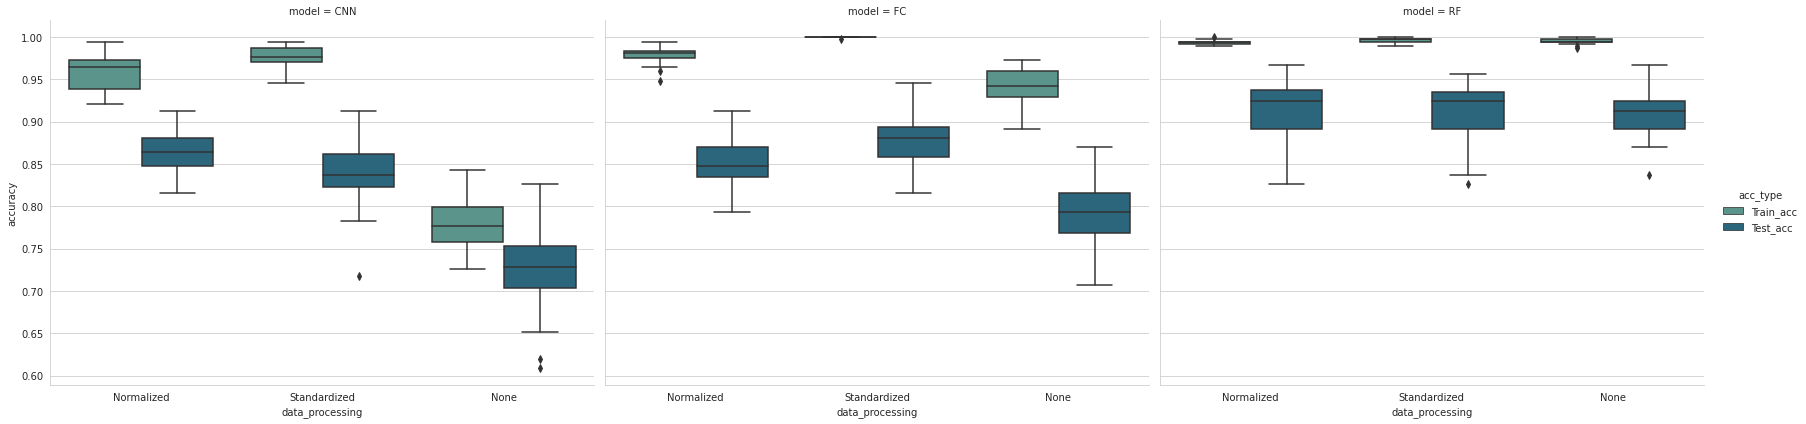

In [15]:
import seaborn as sns 
acc_prev =  pd.read_csv('result/acc_cnn_fc_all_zero').reset_index(drop=True)
acc_prev_rf =  pd.read_csv('result/acc_rf_all_zero').reset_index(drop=True)
acc_all = pd.concat([acc_prev ,  acc_prev_rf]).reset_index(drop=True)
sns.set_style('whitegrid')
sns.catplot(data = acc_all , y='accuracy' , x = 'data_processing' ,
            hue= 'acc_type'  , kind='box' ,  col ='model' , 
            palette = 'crest' , height=6 , aspect=8/6
            )
plt.savefig('result/model_var_rf.jpg')
plt.show()

In [16]:
data_og.describe()

,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,4.600000e+02,4.600000e+02,4.600000e+02,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,-13.665727,-10.585485,-13.672153,-13.524028,-13.598865,-9.545423,-2.479007,-10.270777,-11.095915,...,3.976932e-14,3.684994e-14,4.187235e-14,1.109605,0.566298,0.565308,16.913367,20.985130,14.195144,0.158613
std,109.946267,3.758502,6.281784,3.562725,2.445021,1.872480,7.192002,5.508112,6.885564,5.952367,...,1.828352e-13,1.716889e-13,1.908868e-13,8.512305,2.798337,4.297048,110.659935,138.121021,94.621092,0.603954
min,2.110000,-16.403623,-16.286762,-16.438660,-16.050805,-16.001523,-17.513428,-16.808549,-17.283162,-16.795609,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,-15.157782,-14.772950,-15.097236,-14.486419,-14.402365,-15.235153,0.000000,-15.289121,-14.680062,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23.470000,-14.736025,-13.558464,-14.643783,-13.813854,-13.795609,-14.031779,0.000000,-14.179348,-13.784101,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49.260000,-13.884391,0.000000,-13.880179,-13.312095,-13.246092,0.000000,0.000000,0.000000,-12.544880,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,376.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.674000e-12,1.627000e-12,1.726000e-12,100.000000,35.720000,81.320000,1472.000000,1712.000000,1380.000000,9.074000


## Comparison across Imputation

In [24]:
data_rf = pd.read_csv('../processed_data/train_norm_rf_impute' , index_col=0).reset_index(drop=True)
data_corr = pd.read_csv('../processed_data/train_norm_corr' , index_col=0).reset_index(drop=True)
data_zero = pd.read_csv('../processed_data/train_norm_zero' , index_col=0).reset_index(drop=True)
data_mean = pd.read_csv('../processed_data/train_norm_mean' , index_col=0).reset_index(drop=True)
data_median = pd.read_csv('../processed_data/train_norm_median' , index_col=0).reset_index(drop=True)
data_corr.head(2)

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
0,NS,J1748-2021#2,NS0056,6.25,0.335171,0.168648,0.376587,0.254273,0.287741,0.376253,...,0.039243,0.043996,0.036741,0.331771,0.049034,0.434538,0.905741,0.850661,0.986117,0.694600
1,NS,EXO 1745-248,NS0020,23.47,0.354061,0.569897,0.493711,0.459409,0.481761,0.403466,...,0.040868,0.045665,0.038351,0.453253,0.062636,0.616169,1.001875,0.941022,1.090491,0.705692


In [25]:
acc_rf = mc_validation(gen_model_rf , data_rf , obs_split , model_name = 'RF' , d_type='Normalized' , impute_method='RF')
acc_zero = mc_validation(gen_model_rf , data_zero , obs_split ,model_name = 'RF' , d_type='Normalized' , impute_method='Zero')
acc_mean = mc_validation(gen_model_rf , data_mean , obs_split, model_name = 'RF' , d_type = 'Normalized' ,  impute_method='mean')
acc_median = mc_validation(gen_model_rf , data_median  , obs_split ,  model_name = 'RF' , d_type = 'Normalized' ,  impute_method='median')
acc_corr = mc_validation(gen_model_rf , data_corr  , obs_split ,  model_name = 'RF' , d_type = 'Normalized' ,  impute_method='correlation')


/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


split_no 368


  0%|          | 0/32 [00:00<?, ?it/s]

2/2 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9022


  3%|▎         | 1/32 [00:04<02:13,  4.30s/it]

2/2 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.8804


  6%|▋         | 2/32 [00:08<02:04,  4.15s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8913


  9%|▉         | 3/32 [00:12<02:01,  4.17s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 12%|█▎        | 4/32 [00:16<01:57,  4.18s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 16%|█▌        | 5/32 [00:20<01:51,  4.14s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 19%|█▉        | 6/32 [00:24<01:46,  4.11s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 22%|██▏       | 7/32 [00:28<01:42,  4.09s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 25%|██▌       | 8/32 [00:34<01:47,  4.49s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 28%|██▊       | 9/32 [00:38<01:41,  4.40s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 31%|███▏      | 10/32 [00:42<01:35,  4.33s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 34%|███▍      | 11/32 [00:46<01:29,  4.25s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9565


 38%|███▊      | 12/32 [00:50<01:24,  4.20s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 41%|████      | 13/32 [00:54<01:19,  4.18s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8587


 44%|████▍     | 14/32 [00:58<01:14,  4.13s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 47%|████▋     | 15/32 [01:03<01:09,  4.11s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 50%|█████     | 16/32 [01:07<01:05,  4.09s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 53%|█████▎    | 17/32 [01:11<01:01,  4.09s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 56%|█████▋    | 18/32 [01:15<00:57,  4.10s/it]

2/2 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 59%|█████▉    | 19/32 [01:20<00:58,  4.53s/it]

2/2 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 62%|██████▎   | 20/32 [01:25<00:53,  4.45s/it]

2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 66%|██████▌   | 21/32 [01:29<00:48,  4.37s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 69%|██████▉   | 22/32 [01:33<00:42,  4.30s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 72%|███████▏  | 23/32 [01:37<00:38,  4.24s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 75%|███████▌  | 24/32 [01:41<00:33,  4.18s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 78%|███████▊  | 25/32 [01:45<00:28,  4.14s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 81%|████████▏ | 26/32 [01:49<00:24,  4.12s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 84%|████████▍ | 27/32 [01:53<00:20,  4.11s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 88%|████████▊ | 28/32 [01:57<00:16,  4.09s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 91%|█████████ | 29/32 [02:01<00:12,  4.08s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 94%|█████████▍| 30/32 [02:05<00:08,  4.09s/it]

2/2 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 97%|█████████▋| 31/32 [02:11<00:04,  4.54s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9348


100%|██████████| 32/32 [02:15<00:00,  4.24s/it]
/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


split_no 368


  0%|          | 0/32 [00:00<?, ?it/s]

2/2 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.9022


  3%|▎         | 1/32 [00:04<02:08,  4.15s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8370


  6%|▋         | 2/32 [00:08<02:04,  4.14s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9457


  9%|▉         | 3/32 [00:12<01:59,  4.11s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 12%|█▎        | 4/32 [00:16<01:54,  4.08s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 16%|█▌        | 5/32 [00:20<01:50,  4.08s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 19%|█▉        | 6/32 [00:24<01:45,  4.06s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 22%|██▏       | 7/32 [00:28<01:41,  4.05s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 25%|██▌       | 8/32 [00:32<01:37,  4.05s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 28%|██▊       | 9/32 [00:36<01:33,  4.06s/it]

2/2 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 31%|███▏      | 10/32 [00:42<01:38,  4.47s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 34%|███▍      | 11/32 [00:46<01:33,  4.45s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 38%|███▊      | 12/32 [00:50<01:27,  4.38s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 41%|████      | 13/32 [00:54<01:21,  4.29s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 44%|████▍     | 14/32 [00:58<01:16,  4.23s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 47%|████▋     | 15/32 [01:02<01:10,  4.17s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 50%|█████     | 16/32 [01:06<01:06,  4.13s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 53%|█████▎    | 17/32 [01:10<01:01,  4.12s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 56%|█████▋    | 18/32 [01:15<00:57,  4.10s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9565


 59%|█████▉    | 19/32 [01:19<00:53,  4.11s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9565


 62%|██████▎   | 20/32 [01:23<00:49,  4.10s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8587


 66%|██████▌   | 21/32 [01:27<00:45,  4.10s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 69%|██████▉   | 22/32 [01:31<00:41,  4.10s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 72%|███████▏  | 23/32 [01:37<00:41,  4.56s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 75%|███████▌  | 24/32 [01:41<00:36,  4.51s/it]

2/2 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 78%|███████▊  | 25/32 [01:45<00:30,  4.42s/it]

2/2 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8696


 81%|████████▏ | 26/32 [01:49<00:25,  4.33s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 84%|████████▍ | 27/32 [01:53<00:21,  4.25s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 88%|████████▊ | 28/32 [01:57<00:16,  4.19s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 91%|█████████ | 29/32 [02:01<00:12,  4.15s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 94%|█████████▍| 30/32 [02:06<00:08,  4.13s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9674


 97%|█████████▋| 31/32 [02:10<00:04,  4.11s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9239


100%|██████████| 32/32 [02:14<00:00,  4.19s/it]
/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


split_no 368


  0%|          | 0/32 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9239


  3%|▎         | 1/32 [00:04<02:05,  4.06s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9239


  6%|▋         | 2/32 [00:08<02:02,  4.08s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9565


  9%|▉         | 3/32 [00:12<01:57,  4.07s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9674


 12%|█▎        | 4/32 [00:17<02:12,  4.73s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 16%|█▌        | 5/32 [00:22<02:04,  4.60s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 19%|█▉        | 6/32 [00:26<01:56,  4.47s/it]

2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 22%|██▏       | 7/32 [00:30<01:48,  4.36s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 25%|██▌       | 8/32 [00:34<01:42,  4.27s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 28%|██▊       | 9/32 [00:38<01:36,  4.20s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 31%|███▏      | 10/32 [00:42<01:31,  4.17s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 34%|███▍      | 11/32 [00:46<01:26,  4.12s/it]

2/2 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 38%|███▊      | 12/32 [00:50<01:22,  4.10s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 41%|████      | 13/32 [00:54<01:17,  4.07s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 44%|████▍     | 14/32 [00:59<01:13,  4.08s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 47%|████▋     | 15/32 [01:03<01:09,  4.09s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 50%|█████     | 16/32 [01:07<01:05,  4.10s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 53%|█████▎    | 17/32 [01:11<01:01,  4.11s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 56%|█████▋    | 18/32 [01:17<01:05,  4.65s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 59%|█████▉    | 19/32 [01:21<00:59,  4.57s/it]

2/2 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 62%|██████▎   | 20/32 [01:25<00:53,  4.46s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8478


 66%|██████▌   | 21/32 [01:30<00:47,  4.36s/it]

2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 69%|██████▉   | 22/32 [01:34<00:42,  4.28s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8478


 72%|███████▏  | 23/32 [01:38<00:37,  4.22s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 75%|███████▌  | 24/32 [01:42<00:33,  4.19s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 78%|███████▊  | 25/32 [01:45<00:27,  3.86s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 81%|████████▏ | 26/32 [01:48<00:21,  3.56s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 84%|████████▍ | 27/32 [01:51<00:16,  3.32s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 88%|████████▊ | 28/32 [01:53<00:12,  3.08s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 91%|█████████ | 29/32 [01:56<00:08,  2.88s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 94%|█████████▍| 30/32 [01:58<00:05,  2.80s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 97%|█████████▋| 31/32 [02:01<00:02,  2.86s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


100%|██████████| 32/32 [02:04<00:00,  3.90s/it]
/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


split_no 368


  0%|          | 0/32 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9565


  3%|▎         | 1/32 [00:02<01:29,  2.90s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


  6%|▋         | 2/32 [00:06<01:40,  3.34s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


  9%|▉         | 3/32 [00:09<01:33,  3.24s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 12%|█▎        | 4/32 [00:12<01:28,  3.15s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 16%|█▌        | 5/32 [00:15<01:23,  3.11s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 19%|█▉        | 6/32 [00:18<01:19,  3.06s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 22%|██▏       | 7/32 [00:21<01:15,  3.01s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 25%|██▌       | 8/32 [00:24<01:11,  2.98s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8478


 28%|██▊       | 9/32 [00:27<01:08,  2.98s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 31%|███▏      | 10/32 [00:30<01:04,  2.94s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 34%|███▍      | 11/32 [00:33<01:01,  2.91s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 38%|███▊      | 12/32 [00:36<00:57,  2.89s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 41%|████      | 13/32 [00:38<00:54,  2.89s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 44%|████▍     | 14/32 [00:41<00:52,  2.89s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 47%|████▋     | 15/32 [00:44<00:49,  2.91s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 50%|█████     | 16/32 [00:47<00:46,  2.89s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 53%|█████▎    | 17/32 [00:50<00:43,  2.88s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 56%|█████▋    | 18/32 [00:54<00:44,  3.17s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 59%|█████▉    | 19/32 [00:57<00:39,  3.06s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 62%|██████▎   | 20/32 [00:59<00:36,  3.00s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 66%|██████▌   | 21/32 [01:02<00:32,  2.96s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 69%|██████▉   | 22/32 [01:05<00:29,  2.92s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9674


 72%|███████▏  | 23/32 [01:08<00:26,  2.89s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8696


 75%|███████▌  | 24/32 [01:11<00:23,  2.98s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 78%|███████▊  | 25/32 [01:14<00:20,  2.98s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 81%|████████▏ | 26/32 [01:17<00:17,  2.90s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 84%|████████▍ | 27/32 [01:20<00:14,  2.86s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 88%|████████▊ | 28/32 [01:22<00:11,  2.81s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 91%|█████████ | 29/32 [01:25<00:08,  2.78s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 94%|█████████▍| 30/32 [01:28<00:05,  2.74s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 97%|█████████▋| 31/32 [01:30<00:02,  2.75s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


100%|██████████| 32/32 [01:33<00:00,  2.93s/it]
/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


split_no 368


  0%|          | 0/32 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8696


  3%|▎         | 1/32 [00:02<01:27,  2.83s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


  6%|▋         | 2/32 [00:05<01:22,  2.74s/it]

2/2 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8478


  9%|▉         | 3/32 [00:09<01:34,  3.26s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8696


 12%|█▎        | 4/32 [00:11<01:23,  2.99s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8696


 16%|█▌        | 5/32 [00:14<01:17,  2.86s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 19%|█▉        | 6/32 [00:17<01:12,  2.80s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 22%|██▏       | 7/32 [00:19<01:08,  2.75s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 25%|██▌       | 8/32 [00:22<01:06,  2.75s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9565


 28%|██▊       | 9/32 [00:25<01:02,  2.72s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 31%|███▏      | 10/32 [00:28<00:59,  2.71s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 34%|███▍      | 11/32 [00:30<00:56,  2.69s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 38%|███▊      | 12/32 [00:33<00:53,  2.68s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 41%|████      | 13/32 [00:35<00:50,  2.67s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 44%|████▍     | 14/32 [00:38<00:49,  2.76s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 47%|████▋     | 15/32 [00:41<00:46,  2.76s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 50%|█████     | 16/32 [00:44<00:43,  2.74s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8696


 53%|█████▎    | 17/32 [00:47<00:41,  2.74s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9565


 56%|█████▋    | 18/32 [00:49<00:38,  2.77s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8696


 59%|█████▉    | 19/32 [00:52<00:35,  2.74s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 62%|██████▎   | 20/32 [00:55<00:32,  2.73s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 66%|██████▌   | 21/32 [00:58<00:30,  2.77s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 69%|██████▉   | 22/32 [01:00<00:27,  2.75s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 72%|███████▏  | 23/32 [01:05<00:28,  3.17s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 75%|███████▌  | 24/32 [01:07<00:24,  3.01s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8478


 78%|███████▊  | 25/32 [01:10<00:20,  2.88s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 81%|████████▏ | 26/32 [01:12<00:16,  2.82s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 84%|████████▍ | 27/32 [01:15<00:13,  2.78s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 88%|████████▊ | 28/32 [01:18<00:11,  2.76s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 91%|█████████ | 29/32 [01:21<00:08,  2.73s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 94%|█████████▍| 30/32 [01:23<00:05,  2.74s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 97%|█████████▋| 31/32 [01:26<00:02,  2.72s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8804


100%|██████████| 32/32 [01:29<00:00,  2.79s/it]


In [32]:
acc_data =  pd.concat([acc_zero , acc_mean , acc_median , acc_corr , acc_rf]).reset_index(drop=True)
acc_data

,model,impute_method,data_processing,acc_type,accuracy
0,RF,Zero,Normalized,Train_acc,0.997283
1,RF,Zero,Normalized,Train_acc,0.994565
2,RF,Zero,Normalized,Train_acc,0.994565
3,RF,Zero,Normalized,Train_acc,0.997283
4,RF,Zero,Normalized,Train_acc,0.989130
...,...,...,...,...,...
315,RF,RF,Normalized,Test_acc,0.913043
316,RF,RF,Normalized,Test_acc,0.902174
317,RF,RF,Normalized,Test_acc,0.923913
318,RF,RF,Normalized,Test_acc,0.934783


In [33]:
acc_data.to_csv('result/acc_rf_norm_all')

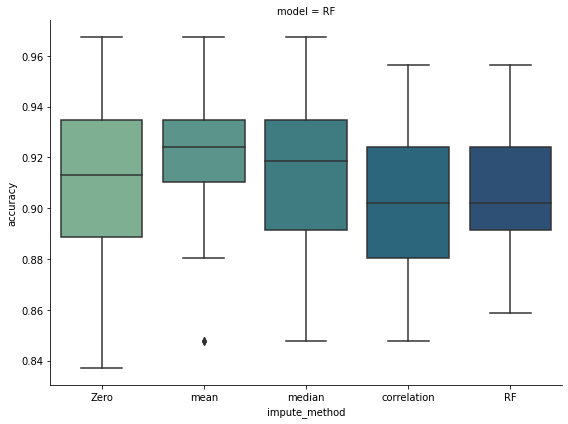

In [39]:
sns.catplot(data = acc_data[acc_data['acc_type']=='Test_acc'] , y='accuracy' , x = 'impute_method' ,
            #hue= 'acc_type'  ,
            kind='box' ,  col ='model' , 
            palette = 'crest' , height=6 , aspect=8/6
            )
plt.savefig('result/model_var_rf.jpg')
plt.show()

> RF correlation did not do much

In [14]:
acc_zero = mc_validation(gen_model_rf , data_corr , src_split ,model_name = 'RF' , d_type='Normalized' , impute_method='Zero')

/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


split_no 368


  0%|          | 0/32 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8804


  3%|▎         | 1/32 [00:09<05:02,  9.77s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8587


  6%|▋         | 2/32 [00:13<03:08,  6.30s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9457


  9%|▉         | 3/32 [00:17<02:34,  5.31s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 12%|█▎        | 4/32 [00:21<02:12,  4.72s/it]

6/6 [==============================] - 1s 8ms/step


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 16%|█▌        | 5/32 [00:25<01:57,  4.35s/it]

6/6 [==============================] - 1s 6ms/step


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 19%|█▉        | 6/32 [00:29<01:48,  4.16s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8478


 22%|██▏       | 7/32 [00:32<01:40,  4.01s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8696


 25%|██▌       | 8/32 [00:35<01:25,  3.54s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 28%|██▊       | 9/32 [00:38<01:18,  3.41s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 31%|███▏      | 10/32 [00:40<01:08,  3.12s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 34%|███▍      | 11/32 [00:43<01:01,  2.94s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 38%|███▊      | 12/32 [00:45<00:55,  2.78s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 41%|████      | 13/32 [00:48<00:53,  2.81s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 44%|████▍     | 14/32 [00:51<00:50,  2.80s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8478


 47%|████▋     | 15/32 [00:55<00:54,  3.21s/it]

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 50%|█████     | 16/32 [01:00<00:57,  3.59s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8587


 53%|█████▎    | 17/32 [01:04<00:55,  3.70s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8261


 56%|█████▋    | 18/32 [01:07<00:52,  3.75s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 59%|█████▉    | 19/32 [01:11<00:49,  3.79s/it]

2/2 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 62%|██████▎   | 20/32 [01:16<00:47,  4.00s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 66%|██████▌   | 21/32 [01:20<00:43,  3.99s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8696


 69%|██████▉   | 22/32 [01:24<00:39,  3.96s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 72%|███████▏  | 23/32 [01:28<00:35,  3.95s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 75%|███████▌  | 24/32 [01:32<00:31,  3.96s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8587


 78%|███████▊  | 25/32 [01:36<00:28,  4.10s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 81%|████████▏ | 26/32 [01:40<00:24,  4.07s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8152


 84%|████████▍ | 27/32 [01:43<00:18,  3.70s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 88%|████████▊ | 28/32 [01:45<00:13,  3.37s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 91%|█████████ | 29/32 [01:48<00:09,  3.18s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 94%|█████████▍| 30/32 [01:51<00:05,  2.99s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 97%|█████████▋| 31/32 [01:53<00:02,  2.92s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


100%|██████████| 32/32 [01:56<00:00,  3.65s/it]


In [16]:
import seaborn as sns

In [15]:
sns.set_style('whitegrid')
sns.catplot(data = acc_zero , y='accuracy' , x = 'impute_method' ,
            hue= 'acc_type'  , kind='box' ,  col ='model' , 
            palette = 'crest' , height=6 , aspect=8/6
            )
#plt.savefig('result/model_var_rf.jpg')
plt.show()

NameError: name 'sns' is not defined

In [13]:
data_rf = pd.read_csv('processed_data/train_norm_rf_impute' , index_col=0).reset_index(drop=True)

In [14]:
acc_rf = mc_validation(gen_model_rf , data_rf , obs_split , model_name = 'RF' , d_type='Normalized' , impute_method='RF')

/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


split_no 368


  0%|          | 0/32 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9348


  3%|▎         | 1/32 [00:09<05:09,  9.97s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8913


  6%|▋         | 2/32 [00:13<03:11,  6.37s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8804


  9%|▉         | 3/32 [00:17<02:35,  5.36s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 12%|█▎        | 4/32 [00:21<02:10,  4.65s/it]

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 16%|█▌        | 5/32 [00:24<01:46,  3.95s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 19%|█▉        | 6/32 [00:27<01:34,  3.62s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8478


 22%|██▏       | 7/32 [00:29<01:22,  3.29s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 25%|██▌       | 8/32 [00:32<01:13,  3.07s/it]

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 28%|██▊       | 9/32 [00:35<01:09,  3.03s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 31%|███▏      | 10/32 [00:38<01:04,  2.92s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8587


 34%|███▍      | 11/32 [00:40<00:59,  2.85s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 38%|███▊      | 12/32 [00:43<00:57,  2.88s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 41%|████      | 13/32 [00:46<00:56,  2.96s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 44%|████▍     | 14/32 [00:49<00:52,  2.94s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 47%|████▋     | 15/32 [00:52<00:49,  2.94s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 50%|█████     | 16/32 [00:55<00:48,  3.05s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 53%|█████▎    | 17/32 [00:59<00:45,  3.06s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8587


 56%|█████▋    | 18/32 [01:01<00:42,  3.01s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 59%|█████▉    | 19/32 [01:04<00:38,  2.98s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 62%|██████▎   | 20/32 [01:07<00:35,  2.96s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 66%|██████▌   | 21/32 [01:10<00:33,  3.04s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 69%|██████▉   | 22/32 [01:13<00:30,  3.01s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9565


 72%|███████▏  | 23/32 [01:16<00:27,  3.02s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 75%|███████▌  | 24/32 [01:19<00:23,  3.00s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 78%|███████▊  | 25/32 [01:23<00:21,  3.04s/it]

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 81%|████████▏ | 26/32 [01:25<00:17,  2.97s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 84%|████████▍ | 27/32 [01:28<00:14,  2.95s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 88%|████████▊ | 28/32 [01:31<00:11,  2.93s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 91%|█████████ | 29/32 [01:34<00:08,  2.92s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 94%|█████████▍| 30/32 [01:37<00:05,  2.99s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 97%|█████████▋| 31/32 [01:40<00:02,  2.97s/it]

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9348


100%|██████████| 32/32 [01:43<00:00,  3.23s/it]


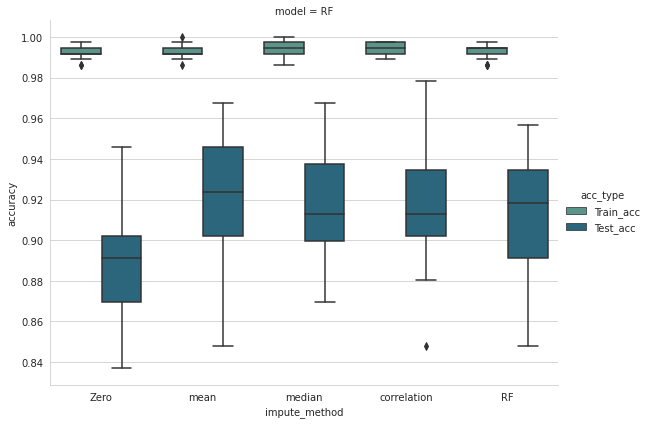

In [17]:
import seaborn as sns 
acc_data = pd.read_csv('result/acc_rf_norm_all')
acc_data = pd.concat([acc_data , acc_rf]).reset_index(drop=True)
sns.set_style('whitegrid')
sns.catplot(data = acc_data , y='accuracy' , x = 'impute_method' ,
            hue= 'acc_type'  , kind='box' ,  col ='model' , 
            palette = 'crest' , height=6 , aspect=8/6
            )
#plt.savefig('result/model_var_rf.jpg')
plt.show()